# bbands

- 가격의 이동평균을 기준 가격으로 삼을 때 가격의 예상 변동성
- 가격이 밴드 바깥으로 벗어날 때 돌파/추세 시그널 또는 과매수/과매도 평균 회귀 시그널

In [ ]:
import pandas as pd
from pandas_datareader import data as pdr
import statistics as stats
import math as math
import matplotlib.pyplot as plt

In [ ]:
start_date = '2017-01-01'
end_date = '2021-01-01'
SRC_DATA_FILENAME = 'goog_data.pkl'

df = pdr.DataReader('GOOG', 'yahoo', start_date, end_date)


close = df['Close']

In [15]:
time_period = 20  # 중앙 밴드 SMA의 히스토리 기간 길이
stdev_factor = 2  # 위/아래 밴드를 위한 표준편차 스케일 팩터
history = []      # 단순 이동평균을 계산하기 위한 가격 히스토리
sma_values = []   # 시각화를 위한 이동평균 가격
upper_band = []   # 위 밴드 값
lower_band = []   # 아래 밴드 값

for close_price in close:
  history.append(close_price)
  if len(history) > time_period: # 'TIME PERIOD' 개수까지 가격 관찰 수 유지하고자 함
    del (history[0])

  sma = stats.mean(history)
  sma_values.append(sma)    # 중앙 밴드의 단순이동평균
  variance = 0              # 분산은 표준편차의 제곱
  for hist_price in history:
    variance = variance + ((hist_price - sma) ** 2) 

  stdev = math.sqrt(variance / len(history)) # 표준편차를 구하고자 제곱근 사용

  upper_band.append(sma + stdev_factor * stdev)
  lower_band.append(sma - stdev_factor * stdev)


In [16]:
df = df.assign(ClosePrice=pd.Series(close, index=df.index))
df = df.assign(Middle=pd.Series(sma_values, index=df.index))
df = df.assign(Upper=pd.Series(upper_band, index=df.index))
df = df.assign(Lower=pd.Series(lower_band, index=df.index))

close_price = df['ClosePrice']
mband = df['Middle']
uband = df['Upper']
lband = df['Lower']

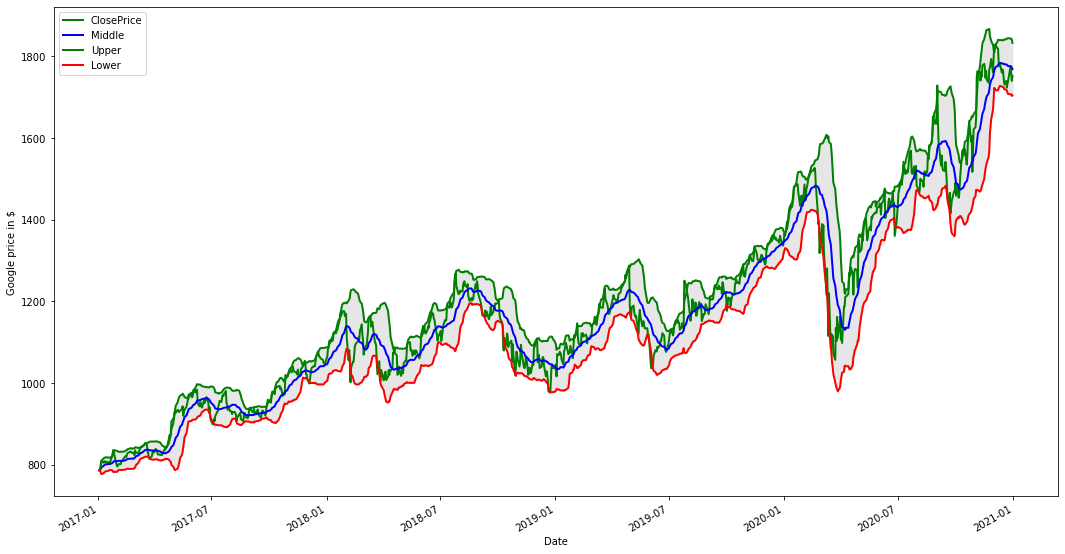

In [32]:

fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(111, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
mband.plot(ax=ax1, color='b', lw=2., legend=True)
uband.plot(ax=ax1, color='g', lw=2., legend=True)
lband.plot(ax=ax1, color='r', lw=2., legend=True)
plt.fill_between(df.index,df['Upper'],df['Lower'], color='0.9')

plt.show()

# pb

In [19]:
df['PB'] = (df['Close'] - df['Lower']) / (df['Upper'] - df['Lower'])

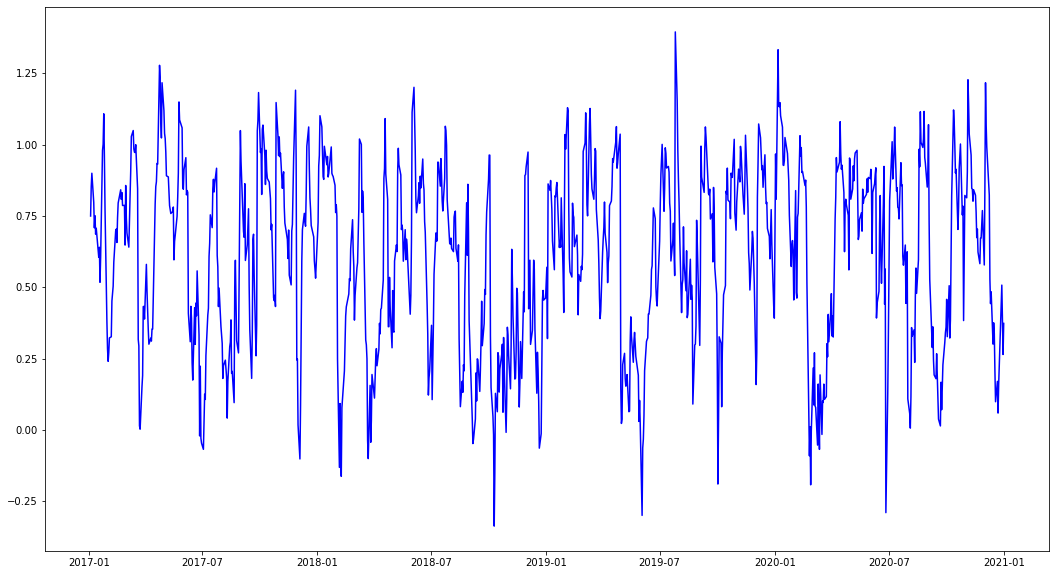

In [43]:
plt.figure(figsize=(18,10))
plt.plot(df.index, df['PB'], color='b', label='%B')

# bandwidth

In [38]:
df['bandwidth'] = (df['Upper']-df['Lower']) / df['Close'].rolling(window=20).mean()*100

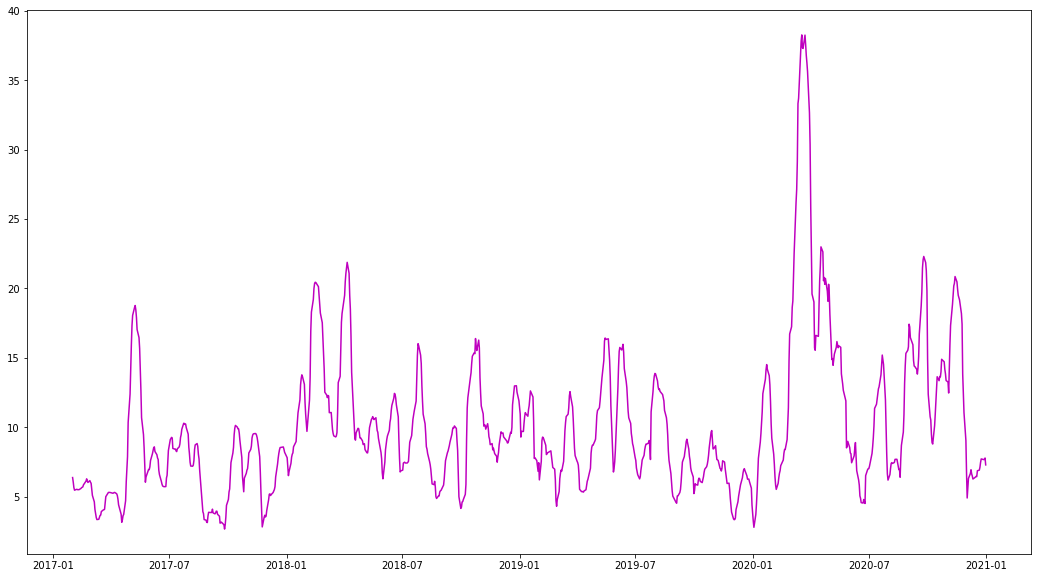

In [42]:
plt.figure(figsize=(18,10))
plt.plot(df.index, df['bandwidth'], color='m', label = 'BandWidth')

- 밴드폭이 6개월 저점을 기록하는 것을 보고 스퀴즈 파악

- %b가 0.8보다 크고, MFI가 80보다 클때 매수
- %b가 0.2보다 작고, MFI가 20보다 작을 때 매도

# MFI

- 현금흐름지표
- 중심가격 * 거래량 = 현금흐름
- PMF = 긍정적 현금흐름
- NMF = 부정적 현금흐름

In [47]:
df['TP'] = (df['High']+df['Low']+df['Close']) / 3
df['PMF'] = 0
df['NMF'] = 0
for i in range(len(df.Close)-1):
    if df.TP.values[i] < df.TP.values[i+1]:
        df.PMF.values[i+1] = df.TP.values[i+1] * df.Volume.values[i+1]
        df.NMF.values[i+1]
    else:
        df.NMF.values[i+1] = df.TP.values[i+1] * df.Volume.values[i+1]
        df.PMF.values[i+1] = 0
df['MFR'] = df.PMF.rolling(window=10).sum() / df.NMF.rolling(window=10).sum()
df['MFI10'] = 100 - 100 / (1 + df['MFR'])

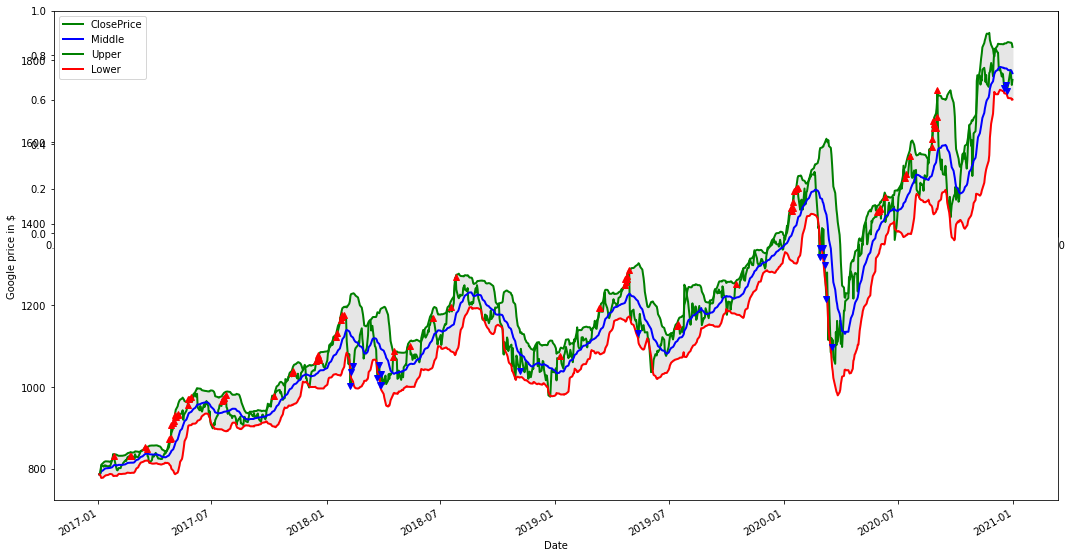

In [58]:

fig = plt.figure(figsize=(18,10))
plt.subplot(2,1,1)
ax1 = fig.add_subplot(111, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
mband.plot(ax=ax1, color='b', lw=2., legend=True)
uband.plot(ax=ax1, color='g', lw=2., legend=True)
lband.plot(ax=ax1, color='r', lw=2., legend=True)
plt.fill_between(df.index,df['Upper'],df['Lower'], color='0.9')

for i in range(len(df.Close)):
    if df.PB.values[i] > 0.8 and df.MFI10.values[i] > 80:
        plt.plot(df.index.values[i], df.Close.values[i], 'r^')
    elif df.PB.values[i] < 0.2 and df.MFI10.values[i] < 20:
        plt.plot(df.index.values[i], df.Close.values[i], 'bv')

plt.show()

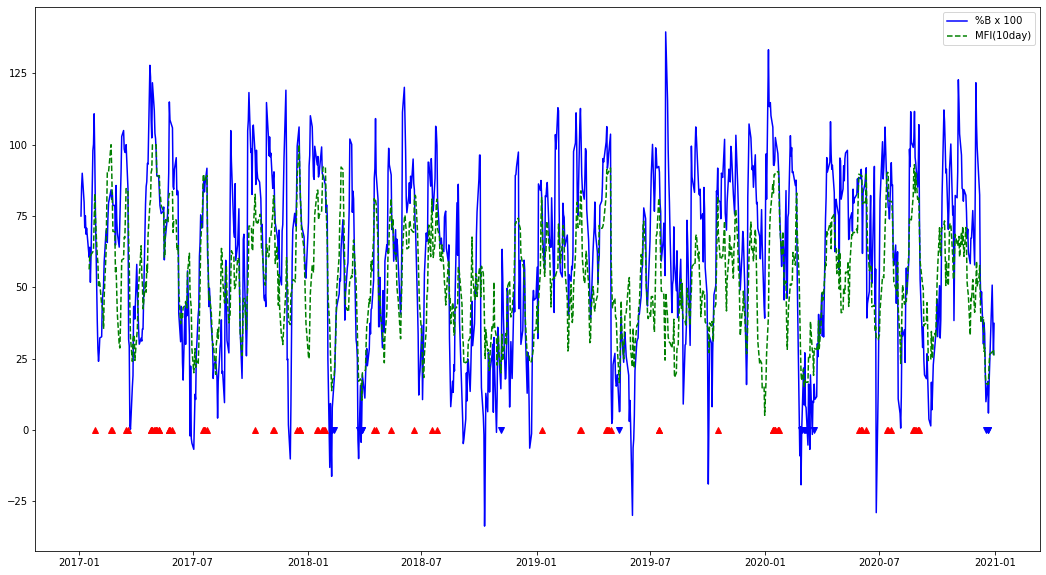

In [62]:
fig = plt.figure(figsize=(18,10))
plt.plot(df.index, df['PB']*100, color='b', label='%B x 100')
plt.plot(df.index, df['MFI10'], 'g--', label='MFI(10day)')
# plt.yticks(-20,0,20,40,60,80,100,120)
for i in range(len(df.Close)):
    if df.PB.values[i] > 0.8 and df.MFI10.values[i] > 80:
        plt.plot(df.index.values[i], 0, 'r^')
    elif df.PB.values[i] < 0.2 and df.MFI10.values[i] < 20:
        plt.plot(df.index.values[i], 0, 'bv')
plt.legend(loc='best')
plt.show();

In [72]:
import pyfolio as pf

In [73]:
return_series = df['Close'].pct_change().fillna(0)

In [75]:
pf.create_returns_tear_sheet(return_series)

Start date,2017-01-03
End date,2020-12-31
Total months,47
,Backtest
Annual return,22.2%
Cumulative returns,122.8%
Annual volatility,27.7%
Sharpe ratio,0.86
Calmar ratio,0.72
Stability,0.84
Max drawdown,-30.8%


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'